# [**Estimation de densité par noyaux des distributions d'espèces**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/1_6_neighbors/plot_species_kde.ipynb)<br/>([_Kernel Density Estimate of Species Distributions_](https://scikit-learn.org/stable/auto_examples/neighbors/plot_species_kde.html))

Ceci montre un exemple d'une requête basée sur les voisins (en particulier une estimation de densité par noyaux) sur des données géospatiales, en utilisant un Ball Tree construit à partir de la métrique de distance Haversine - c'est-à-dire des distances sur des points de latitude/longitude. L'ensemble de données est fourni par Phillips et al. (2006). Si disponible, l'exemple utilise [**basemap**](https://matplotlib.org/basemap/) pour tracer les côtes et les frontières nationales de l'Amérique du Sud.

Cet exemple n'effectue aucune apprentissage sur les données (voir [**Modélisation de la distribution des espèces**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/applications/plot_species_distribution_modeling.ipynb) pour un exemple de classification basée sur les attributs de cet ensemble de données). Il montre simplement l'estimation de densité par noyaux des points de données observés dans des coordonnées géospatiales.

Les deux espèces sont :

- [**“Bradypus variegatus”**](https://www.iucnredlist.org/species/3038/210442893), le paresseux à gorge brune.
- [**“Microryzomys minutus”**](https://www.iucnredlist.org/species/13408/115111911), également connu sous le nom de Rat des rizières forestières, un rongeur qui vit au Pérou, en Colombie, en Équateur, au Pérou et au Venezuela.

## Références

[**“Maximum entropy modeling of species geographic distributions”**](http://rob.schapire.net/papers/ecolmod.pdf) S. J. Phillips, R. P. Anderson, R. E. Schapire - Ecological Modelling, 190:231-259, 2006.

 - computing KDE in spherical coordinates
 - plot coastlines from coverage
 - computing KDE in spherical coordinates
 - plot coastlines from coverage


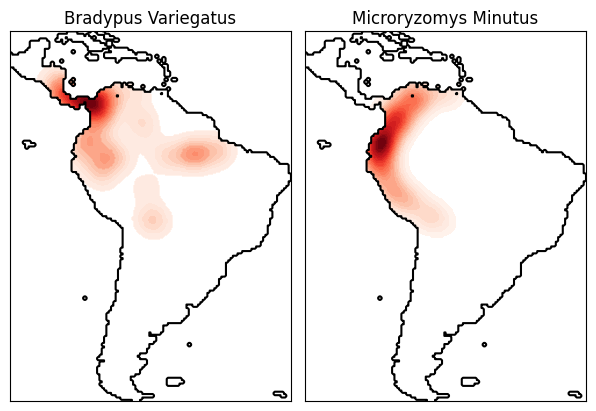

In [1]:
# Author: Jake Vanderplas <jakevdp@cs.washington.edu>
#
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_species_distributions
from sklearn.neighbors import KernelDensity

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap

    basemap = True
except ImportError:
    basemap = False


def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)


# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ["Bradypus Variegatus", "Microryzomys Minutus"]

Xtrain = np.vstack([data["train"]["dd lat"], data["train"]["dd long"]]).T
ytrain = np.array(
    [d.decode("ascii").startswith("micro") for d in data["train"]["species"]],
    dtype="int",
)
Xtrain *= np.pi / 180.0  # Convert lat/long to radians

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = xy[land_mask]
xy *= np.pi / 180.0

# Plot map of South America with distributions of each species
fig = plt.figure()
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(
        bandwidth=0.04, metric="haversine", kernel="gaussian", algorithm="ball_tree"
    )
    kde.fit(Xtrain[ytrain == i])

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999, dtype="int")
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

    if basemap:
        print(" - plot coastlines using basemap")
        m = Basemap(
            projection="cyl",
            llcrnrlat=Y.min(),
            urcrnrlat=Y.max(),
            llcrnrlon=X.min(),
            urcrnrlon=X.max(),
            resolution="c",
        )
        m.drawcoastlines()
        m.drawcountries()
    else:
        print(" - plot coastlines from coverage")
        plt.contour(
            X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid"
        )
        plt.xticks([])
        plt.yticks([])

    plt.title(species_names[i])

plt.show()